In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
import requests
import itertools
import math
from tqdm import tqdm
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point

In [2]:
df_districts = gpd.read_file('data/bcn/spatial/districtes.geojson')
df_barris = gpd.read_file('data/bcn/spatial/gran-barri.geojson')

In [3]:
df = pd.read_csv('data/bcn/flickr_raw.csv')
df

,Unnamed: 0,url,lat,long,tag
0,0,https://live.staticflickr.com/8114/8680653361_...,41.491409,1.653010,barcelona
1,1,https://live.staticflickr.com/8790/28308123815...,41.384271,2.176183,barcelona
2,2,https://live.staticflickr.com/65535/4977197167...,41.375805,2.177964,barcelona
3,3,https://live.staticflickr.com/2435/3534961040_...,41.430783,2.109375,barcelona
4,4,https://live.staticflickr.com/3562/3516776850_...,41.430783,2.109375,barcelona
...,...,...,...,...,...
25481,56921,https://live.staticflickr.com/4822/30882167687...,41.488911,2.142869,sant marti
25482,56922,https://live.staticflickr.com/65535/4805110300...,41.488861,2.142861,sant marti
25483,56923,https://live.staticflickr.com/65535/4911612506...,41.405166,2.184772,sant marti
25484,56924,https://live.staticflickr.com/65535/4931242327...,41.404072,2.183844,sant marti


In [5]:
df['district'] = ""
df['neighborhood'] = ""

with tqdm(total=df.shape[0]) as pbar: 
    for index, row in df.iterrows():
        lat = row.lat
        long = row.long
        point = Point(long, lat)

        for district in range(0,len(df_districts)):
            polygon = shape(df_districts['geometry'][district])
            if polygon.contains(point):
                df.loc[index, 'district'] = df_districts['NOM'][district]

        for neighborhood in range(0,len(df_barris)):
            polygon = shape(df_barris['geometry'][neighborhood])
            if polygon.contains(point):
                df.loc[index, 'neighborhood'] = df_barris['NOM'][neighborhood]
        pbar.update(1)

100%|██████████| 25486/25486 [05:35<00:00, 75.97it/s]


In [6]:
df = df.drop(['Unnamed: 0', 'tag'], axis=1).reset_index().drop('index', axis=1)
df

,url,lat,long,district,neighborhood
0,https://live.staticflickr.com/8114/8680653361_...,41.491409,1.653010,,
1,https://live.staticflickr.com/8790/28308123815...,41.384271,2.176183,Ciutat Vella,el Barri Gòtic\r\n
2,https://live.staticflickr.com/65535/4977197167...,41.375805,2.177964,Ciutat Vella,el Barri Gòtic\r\n
3,https://live.staticflickr.com/2435/3534961040_...,41.430783,2.109375,,
4,https://live.staticflickr.com/3562/3516776850_...,41.430783,2.109375,,
...,...,...,...,...,...
25481,https://live.staticflickr.com/4822/30882167687...,41.488911,2.142869,,
25482,https://live.staticflickr.com/65535/4805110300...,41.488861,2.142861,,
25483,https://live.staticflickr.com/65535/4911612506...,41.405166,2.184772,Sant Martí,el Clot i el Camp de l'Arpa\r\n\r\n
25484,https://live.staticflickr.com/65535/4931242327...,41.404072,2.183844,Eixample,la Sagrada Família


In [7]:
df = df[df['district']!=""]
df = df[df['neighborhood']!=""]

In [8]:
df = df.drop_duplicates(subset=['url']).reset_index().drop('index', axis=1)

In [9]:
df

,url,lat,long,district,neighborhood
0,https://live.staticflickr.com/8790/28308123815...,41.384271,2.176183,Ciutat Vella,el Barri Gòtic\r\n
1,https://live.staticflickr.com/65535/4977197167...,41.375805,2.177964,Ciutat Vella,el Barri Gòtic\r\n
2,https://live.staticflickr.com/3002/2814274154_...,41.400360,2.180914,Eixample,el Fort Pienc
3,https://live.staticflickr.com/2680/4324456481_...,41.400360,2.180914,Eixample,el Fort Pienc
4,https://live.staticflickr.com/4835/45333422864...,41.386025,2.172900,Ciutat Vella,el Barri Gòtic\r\n
...,...,...,...,...,...
17934,https://live.staticflickr.com/4764/39843837144...,41.415638,2.193158,Sant Andreu,"la Sagrera, el Congrés i Navas\r\n\r\n\r\n"
17935,https://live.staticflickr.com/1756/40866540930...,41.389141,2.193703,Sant Martí,"el Parc, la Llacuna i la Vila Olímpica\r\n\r\n"
17936,https://live.staticflickr.com/65535/4911612506...,41.405166,2.184772,Sant Martí,el Clot i el Camp de l'Arpa\r\n\r\n
17937,https://live.staticflickr.com/65535/4931242327...,41.404072,2.183844,Eixample,la Sagrada Família


In [11]:
df.to_csv('flickr.csv', index=False)

In [22]:
n_images = df['district'].value_counts().rename_axis('NOM').reset_index(name='counts')

Text(0.5, 212.16666666666666, 'Longitude')

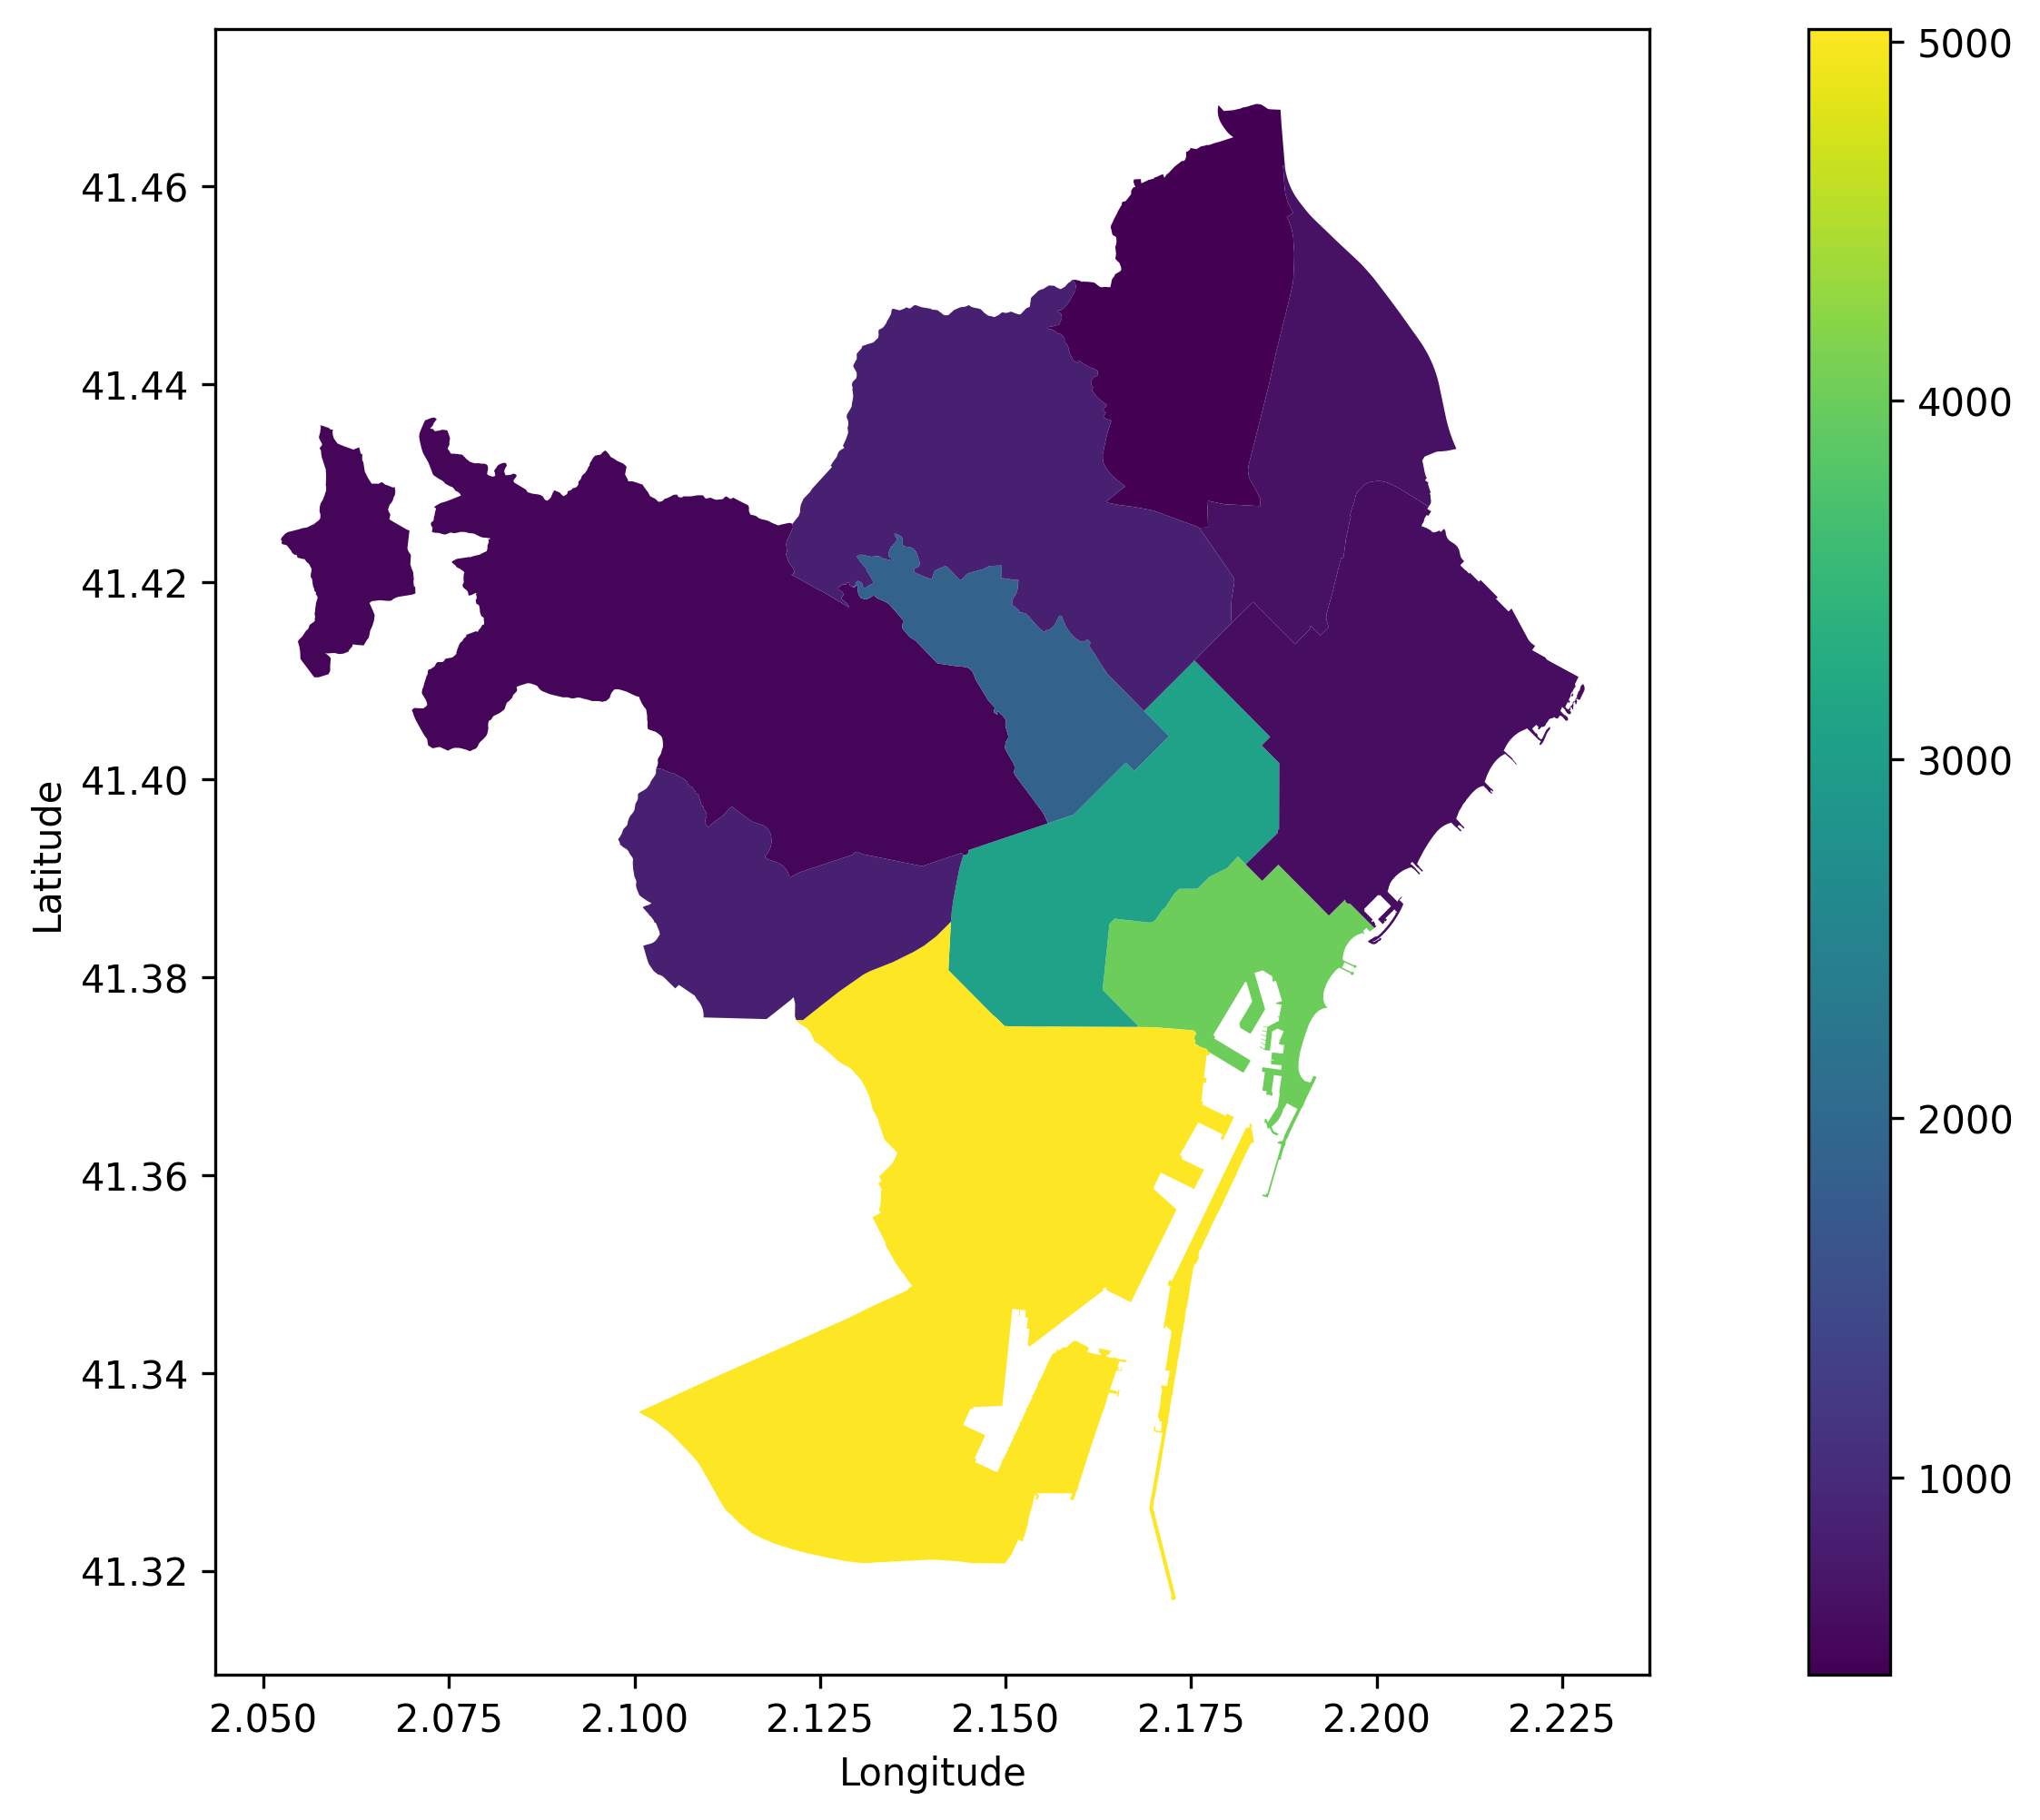

In [23]:
df_districts = df_districts.merge(n_images, on='NOM', how='left')
df_districts['counts'] = df_districts['counts'].fillna(0)
df_districts.plot(column='counts', legend=True, figsize=(15,8))
plt.ylabel('Latitude')
plt.xlabel('Longitude')

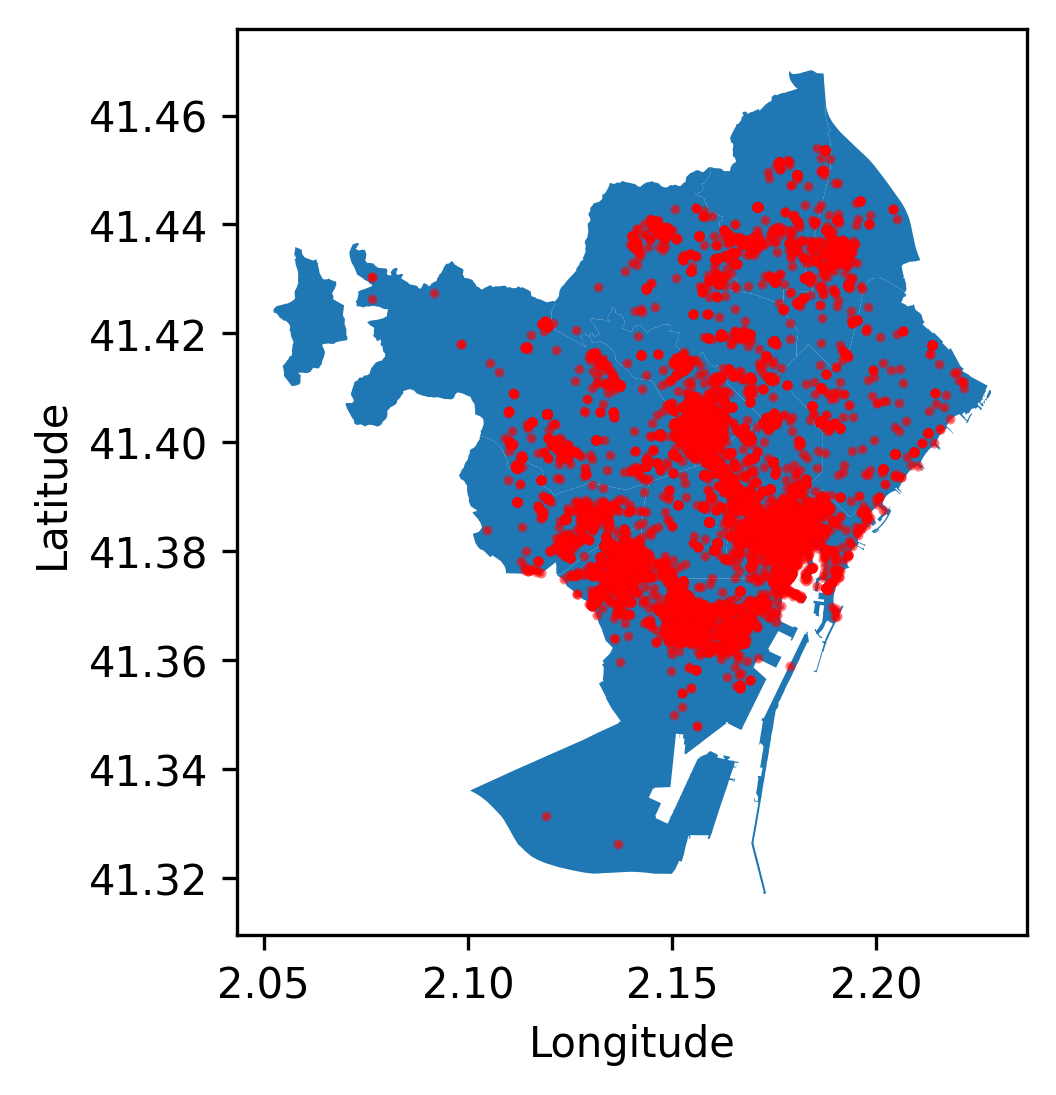

In [26]:
df_districts['geometry'].plot()
plt.rcParams['figure.dpi'] = 300
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.scatter(df['long'], df['lat'], alpha=0.5, s=2, c='red')

## Download
Download images into train / val folders with 90% and 10% respectively, splitting the images according to the district.

In [ ]:
with tqdm(total=df.shape[0]) as pbar: 
    for index, row in df.iterrows():

        if not os.path.exists(f'flickr/train/{row.district}'):
            os.makedirs(f'flickr/train/{row.district}')
        if not os.path.exists(f'flickr/val/{row.district}'):
            os.makedirs(f'flickr/val/{row.district}')

        path, dirs, files = next(os.walk(f'flickr/train/{row.district}'))
        file_count = len(files)

        if (file_count < (0.9 * len(df[df['district'] == row.district]))):
            path = 'flickr/train'
        else:
            path = 'flickr/val'
            
        try:
            urllib.request.urlretrieve(row.url, f'{path}/{row.district}/{index}.jpeg')
            image = Image.open(f'{path}/{row.district}/{index}.jpeg') 
            image = image.resize((256, 256), Image.ANTIALIAS)
            image.save(f'{path}/{row.district}/{index}.jpeg')
        except:
            print("Image not available.")
        pbar.update(1)